In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

Max: 1.0078362951206177 Mean: 1.0077991721696231
Max: 1.0862789832201307 Mean: 1.0810945779781431
Max: 1.35266505364125 Mean: 1.3065909801192557
Max: 4.762616621335881 Mean: 3.6835996458010003


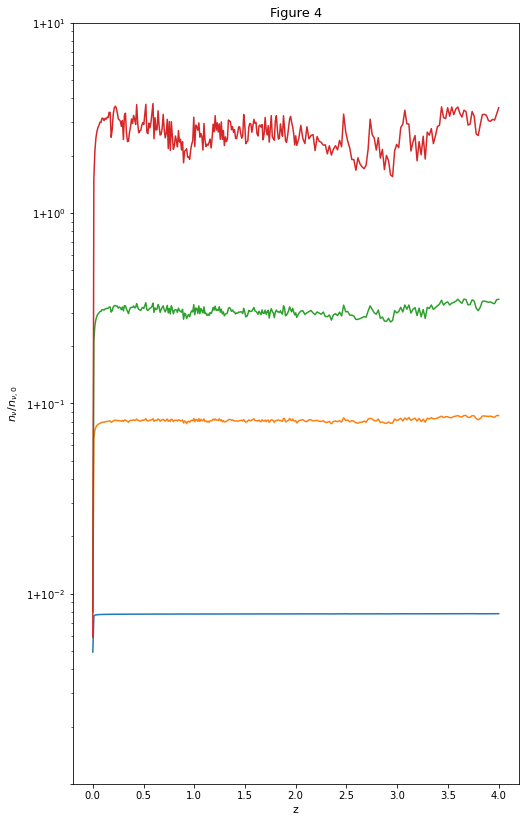

In [2]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Load data, which function uses.
u_all = fct.load_u_sim()
def n_nu_of_redshift(m_sim_eV, m_nu_eV):
    
    # Convert to momenta. 
    p, _ = fct.u_to_p_eV(u_all, m_sim_eV, m_nu_eV)
    #NOTE: has (10000, 100) shape, ndim = 2

    zeds = CC.ZEDS

    n_nus = np.zeros(len(zeds))
    for i, _ in enumerate(zeds):

        # Calculate number density.
        n_nus[i] = fct.number_density(p[:,0], p[:,i]).value

    np.save(f'neutrino_data/number_densities_at_z_{m_nu_eV.value}eV.npy', n_nus)


# Plotting.
fig, ax = plt.subplots(1,1, figsize=(8,14))

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m in enumerate(masses):
    n_nu_of_redshift(CC.NU_MASS, m)

    n = np.load(f'neutrino_data/number_densities_at_z_{m.value}eV.npy')/CC.N0
    print('Max:', np.max(n),'Mean:', np.mean(n))

    ax.semilogy(CC.ZEDS, n-1)

ax.set_title('Figure 4')
ax.set_xlabel('z')
ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
ax.set_ylim(1e-3, 1e1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))
plt.savefig('check_plots/figure_4.pdf')
plt.show()

## Integrand for number density, momentum distr.

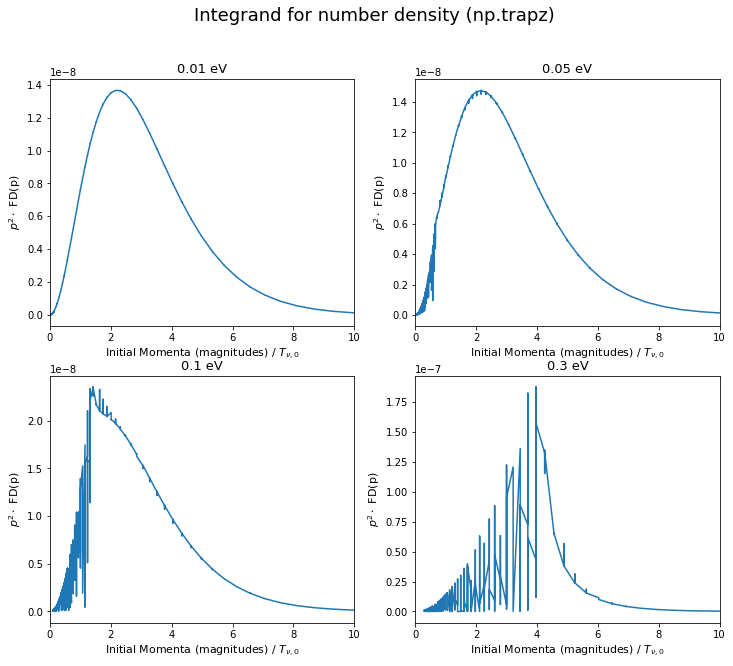

In [3]:
# Load data, which function uses.
u_all = fct.load_u_sim()
def momentum_shape(m_sim_eV, m_nu_eV):

    # Get momenta.
    u0, u1 = u_all[:,0,:], u_all[:,-1,:]
    p0, y0 = fct.u_to_p_eV(u0, m_sim_eV, m_nu_eV)
    p1, _ = fct.u_to_p_eV(u1, m_sim_eV, m_nu_eV)

    # Sort.
    order = p0.argsort()
    p0_sort, p1_sort = p0[order], p1[order]

    # Fermi-Dirac values with momentum at end of sim.
    FDvals = fct.Fermi_Dirac(p1_sort)

    return p0_sort.value, FDvals, y0[order]


fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle('Integrand for number density (np.trapz)', fontsize=18)

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m in enumerate(masses):
    p0_sort, FDvals, y0 = momentum_shape(CC.NU_MASS, m)
    y = p0_sort**2. * FDvals

    i = 0
    if j in (2,3):
        i = 1
        j -= 2

    axs[i,j].plot(y0, y,)# lw=0.3)
    axs[i,j].set_title(f'{m.value} eV')
    axs[i,j].set_xlabel(r'Initial Momenta (magnitudes) / $T_{\nu ,0}$')
    axs[i,j].set_ylabel(r'$p^2 \cdot$ FD(p)')

    # trunc_y = y0[np.abs(y0-(10.)).argmin()]
    # axs[i,j].axvline(trunc_y, c='r', ls=':')
    axs[i,j].set_xlim(0,10)


plt.savefig('check_plots/figure_4_momenta.pdf')
plt.show()